In [3]:
%matplotlib inline
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sbn

In [4]:
sys.path.append('../') # Add directory of avatar_data.py to path
import avatar_data

## Data preprocessing

Read the data in, choosing which targets we're going to use

In [5]:
file_index = 1
feature_labels = ['LController','RController','Headset']
target_labels = ['Front', 'Back','LeftElbow','RightElbow','LeftKnee','RightKnee']
features, targets = avatar_data.read_data('../../',k=file_index, target_labels=target_labels) 

['../../data/steamvr_avatar_0', '../../data/steamvr_avatar_1', '../../data/steamvr_avatar_10', '../../data/steamvr_avatar_11', '../../data/steamvr_avatar_12', '../../data/steamvr_avatar_13', '../../data/steamvr_avatar_14', '../../data/steamvr_avatar_15', '../../data/steamvr_avatar_16', '../../data/steamvr_avatar_17', '../../data/steamvr_avatar_18', '../../data/steamvr_avatar_19', '../../data/steamvr_avatar_2', '../../data/steamvr_avatar_20', '../../data/steamvr_avatar_3', '../../data/steamvr_avatar_4', '../../data/steamvr_avatar_5', '../../data/steamvr_avatar_6', '../../data/steamvr_avatar_7', '../../data/steamvr_avatar_8', '../../data/steamvr_avatar_9', '../../data/steamVRLogs']
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(3,)
(6,)
(

Remove outliers, using an Isolation Forest. Outliers are mostly caused by occlusion of the sensors

1149


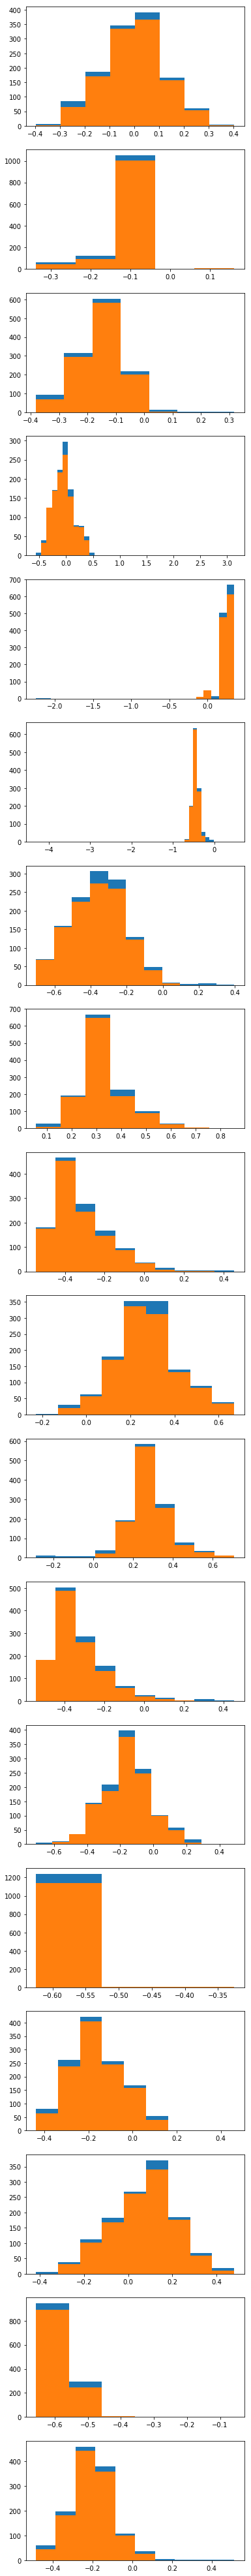

99 outliers were removed, leaving 1149 samples


In [6]:
import outlier_removal
# Our estimations of the number of outliers in the feature and target sets. 
targ_outlier_frac = 0.05
feat_outlier_frac = 0.05
targets_pruned, features_pruned = outlier_removal.remove_outliers(targets,features,targ_outlier_frac,feat_outlier_frac)
# Print out how many outliers were removed. 
print "{0} outliers were removed, leaving {1} samples".format(features.shape[0] - features_pruned.shape[0], features_pruned.shape[0])

## Construct the sci-kit learn pipeline

Split up the data set into training and test

In [7]:
from sklearn.model_selection import train_test_split
# Split up dataset into training and test set
test_fraction = 0.4
features_train, features_test, targets_train, targets_test = train_test_split(
    features_pruned,targets_pruned, test_size=test_fraction, random_state=0)    
print features_train.shape, features_pruned.shape, targets_pruned.shape, targets_train.shape

(689, 9) (1149, 9) (1149, 18) (689, 18)


Set up the grid search

In [8]:
# create MLPRegressor to be optimized 
reg = MLPRegressor(solver='lbfgs',activation='relu') 

# set up the pipeline for hyperparameter optimization
pipe = Pipeline(steps=[('MLPReg',reg)])

# 5-fold validation
cv_iter = KFold(n_splits=5)

hidden_layer_grid = [(x,x) for x in range(1,100,10)]
alpha_grid = np.logspace(-5,3,10)
"""
estimator = GridSearchCV(pipe, 
                        dict(MLPReg__hidden_layer_sizes=hidden_layer_grid,
                             MLPReg__alpha=alpha_grid),
                        cv = cv_iter)
"""

# Run with our best estimator rather than grid searching. 
estimator = MLPRegressor(solver='lbfgs', activation='relu', alpha=0.0046, hidden_layer_sizes=(81,81))

In [9]:
estimator.fit(features_train, targets_train)

MLPRegressor(activation='relu', alpha=0.0046, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(81, 81), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [10]:
print(estimator.best_estimator_)                 # Summary of parameters for best predictor

AttributeError: 'MLPRegressor' object has no attribute 'best_estimator_'

In [11]:
print('Best accuracy {:4.2f}% '.format(100*estimator.best_score_))#, end='')
print('was achieved with: \n{}'.format(estimator.best_params_))

AttributeError: 'MLPRegressor' object has no attribute 'best_score_'

In [12]:
target_predicted = estimator.predict(features_test)
test_score = estimator.score(features_test, targets_test)
print('Score on test data: {:4.2f}%'.format(test_score*100))

Score on test data: 66.48%


Do some simple plotting comparing for Front

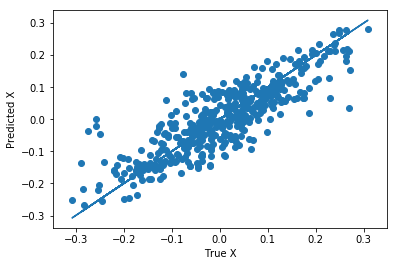

In [13]:
plt.scatter(targets_test[:,0],target_predicted[:,0]) # Predicted vs true of X coordinates
plt.plot(targets_test[:,0],targets_test[:,0])
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.show()

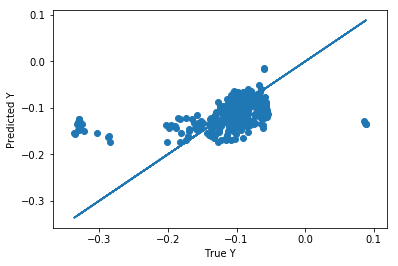

In [14]:
plt.scatter(targets_test[:,1],target_predicted[:,1]) # Predicted vs true of Y coordinates (height!)
plt.plot(targets_test[:,1],targets_test[:,1])
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.show()

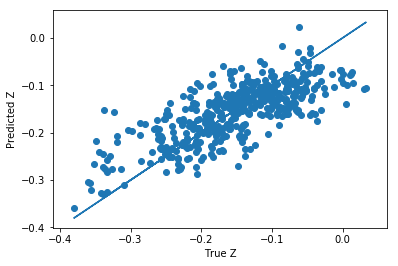

In [15]:
plt.scatter(targets_test[:,2],target_predicted[:,2]) # Predicted vs true of Z coordinates
plt.plot(targets_test[:,2],targets_test[:,2])
plt.xlabel("True Z")
plt.ylabel("Predicted Z")
plt.show()

Make violin plots showing the distribution of error for each feature in Euclidean space

In [16]:
# list of lists of distances between predicted and target for each target position
targets_dist = [[] for i in range(targets_test.shape[1] / 3)]
for test, pred in zip(targets_test, target_predicted): 
    for i in range(len(test) / 3): 
        test_vec = np.array([test[i * 3 + j] for j in range(3)])
        pred_vec = np.array([pred[i * 3 + j] for j in range(3)])
        dist = np.linalg.norm(test_vec - pred_vec)
        targets_dist[i].append(dist)
# convert into numpy array
targets_dist = np.array(targets_dist)

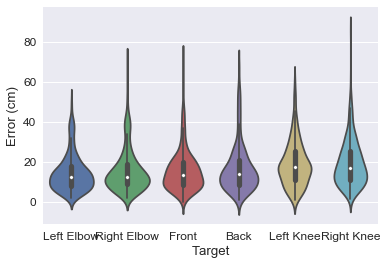

In [17]:
x = ['Left Elbow', 'Right Elbow', 'Front', 'Back', 'Left Knee', 'Right Knee']

import pandas as pd
sbn.set(font_scale=1.2)
scaled_dist = targets_dist * 180
df = pd.DataFrame(scaled_dist.T, columns=x)
meltdf = df.melt(var_name='Target', value_name='Error (cm)')
ax = sbn.violinplot(x=meltdf['Target'], y=meltdf['Error (cm)'])
#ax = sbn.violinplot(y=df['Left Elbow'])
ax.figure.savefig("error_plot.png")


## Render predicted positions using the new Unity renderer.

In [30]:
sys.path.append('../rendering')
import AvatarServer

Generate labels for the features and targets, so dictionaries can be made

In [31]:

#Generate the CSV labels again. this needs to be wrapped up. 
feature_labels_full = [avatar_data.generate_labels_for_target(label) for label in feature_labels]
flatten = lambda l: [item for sublist in l for item in sublist]
feature_labels_full = flatten(feature_labels_full)
target_labels_full = [avatar_data.generate_labels_for_target(label) for label in target_labels]
target_labels_full = flatten(target_labels_full)
pred_labels = [label + str("Pred") for label in target_labels]
pred_labels_full = [avatar_data.generate_labels_for_target(label) for label in pred_labels]
pred_labels_full = flatten(pred_labels_full)

In [33]:
del server

In [34]:
server = AvatarServer.AvatarServer(port=54321)

Connect to the client. This will block until a client connect.
Then send all the features, targets and predicted. 

In [ ]:
server.connect_to_client()
for f, t, p in zip(features_test,targets_test,target_predicted):
    # TODO - Wrap this up in a nice method.
    feature_dict = avatarServer.generate_dictionary_for_data(f, feature_labels_full)
    target_dict = avatarServer.generate_dictionary_for_data(t, target_labels_full)
    pred_dict = avatarServer.generate_dictionary_for_data(p, pred_labels_full)
    message = avatarServer.merge_dictionaries(feature_dict, target_dict, pred_dict)
    server.send_object(message)
server.close_connection()

Waiting for client to connect...


In [29]:
server.close_connection()